### Objective
<p>Your objective is to produce a model to predict positive moves (up trend) using machine learning
models as specified in the below section. </p>
<p>Your proposed solution should be comprehensive with the detailed feature engineering and model architecture</p>

<p>
<ul>
<li>Choose one ticker of your interest from the index, equity, ETF, crypto token, or commodity</li>
<li>Predict trend only, for a short-term return (example: daily, 6 hours). Limit prediction to
binomial classification: the dependent variable is best labeled [0, 1]. Avoid using [-1, 1] as class
labels</li>
<li>Analysis should be comprehensive with detailed feature engineering, data pre-processing, model
building, and evaluation</li></ul>
</p>

<p>Devise your own approach on how to categorise extremely small near-zero returns (drop from
training sample, group with positive/negative). The threshold will strongly depend on your
ticker. Example: small positive returns below 0.25% can be labelled as negative</p>


## Problem Statement
The objective is to predict positive market movement based on classification algorithm. In this lab, we'll use Logistic Regression to predict market direction and devise a trading strategies based on it.

## The workflow
We'll employ logistic regressor from scikit-learn for stock / equity index trend prediction.
<p>
<table>
<thead>
<tr>
<th style="text-align:left">Steps</th>
<th style="text-align:left">Workflow</th>
<th style="text-align:left">Remarks</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">Step 1</td>
<td style="text-align:left">Ideation</td>
<td style="text-align:left">Predict the trend of the underlying from the given dataset</td>
</tr>
<tr>
<td style="text-align:left">Step 2</td>
<td style="text-align:left">Data Collection</td>
<td style="text-align:left">Load the dataset from quantmod library page</td>
</tr>
<tr>
<td style="text-align:left">Step 3</td>
<td style="text-align:left">Exploratory Data Analysis</td>
<td style="text-align:left">Study summary statistics</td>
</tr>
<tr>
<td style="text-align:left">Step 4</td>
<td style="text-align:left">Cleaning Dataset</td>
<td style="text-align:left">Data already cleaned, no further imputation required</td>
</tr>
<tr>
<td style="text-align:left">Step 5</td>
<td style="text-align:left">Transformation</td>
<td style="text-align:left">Perform feature scaling based on EDA</td>
</tr>
<tr>
<td style="text-align:left">Step 6</td>
<td style="text-align:left">Modeling</td>
<td style="text-align:left">Building and training linear regressor</td>
</tr>
<tr>
<td style="text-align:left">Step 7</td>
<td style="text-align:left">Metrics</td>
<td style="text-align:left">Validating the model performance using score method</td>
</tr>
</tbody>
</table>

In [23]:

# install packages
%pip install numba


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

# Quantmod
from quantmod.datasets import fetch_historical_data
from quantmod.timeseries import *
from quantmod.indicators import BBands
import shap
# Plotting
import matplotlib.pyplot as plt
# Classifier
from xgboost import XGBClassifier, plot_importance, to_graphviz

# Classifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    TimeSeriesSplit,
                                    GridSearchCV
                                    )

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
                            accuracy_score,
                            f1_score,
                            log_loss,
                            RocCurveDisplay,
                            ConfusionMatrixDisplay,
                            classification_report
                            )

# Analysis
import quantstats_lumi as qs

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [153]:
# Get SPY option chain
sp500 = yf.Ticker('NVDA')
df = sp500.history(period="max", interval="1h")

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-10-10 09:30:00-04:00,12.075000,12.124320,11.580000,11.663000,18114806,0.0,0.0
2022-10-10 10:30:00-04:00,11.661000,11.681000,11.408120,11.571500,11234205,0.0,0.0
2022-10-10 11:30:00-04:00,11.571000,11.694990,11.516001,11.523500,8718422,0.0,0.0
2022-10-10 12:30:00-04:00,11.523001,11.572001,11.446000,11.565001,5600292,0.0,0.0
2022-10-10 13:30:00-04:00,11.564000,11.808001,11.561800,11.699100,8820883,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-07 11:30:00-04:00,128.599899,129.649994,128.550003,129.556305,46140495,0.0,0.0
2024-10-07 12:30:00-04:00,129.559402,129.699997,128.809998,129.429703,29112870,0.0,0.0
2024-10-07 13:30:00-04:00,129.429993,130.639999,129.169998,129.729996,49595566,0.0,0.0


In [154]:
df.info

<bound method DataFrame.info of                                  Open        High         Low       Close  \
Datetime                                                                    
2022-10-10 09:30:00-04:00   12.075000   12.124320   11.580000   11.663000   
2022-10-10 10:30:00-04:00   11.661000   11.681000   11.408120   11.571500   
2022-10-10 11:30:00-04:00   11.571000   11.694990   11.516001   11.523500   
2022-10-10 12:30:00-04:00   11.523001   11.572001   11.446000   11.565001   
2022-10-10 13:30:00-04:00   11.564000   11.808001   11.561800   11.699100   
...                               ...         ...         ...         ...   
2024-10-07 11:30:00-04:00  128.599899  129.649994  128.550003  129.556305   
2024-10-07 12:30:00-04:00  129.559402  129.699997  128.809998  129.429703   
2024-10-07 13:30:00-04:00  129.429993  130.639999  129.169998  129.729996   
2024-10-07 14:30:00-04:00  129.729996  129.779907  127.940002  128.244995   
2024-10-07 15:30:00-04:00  128.250000  128.6

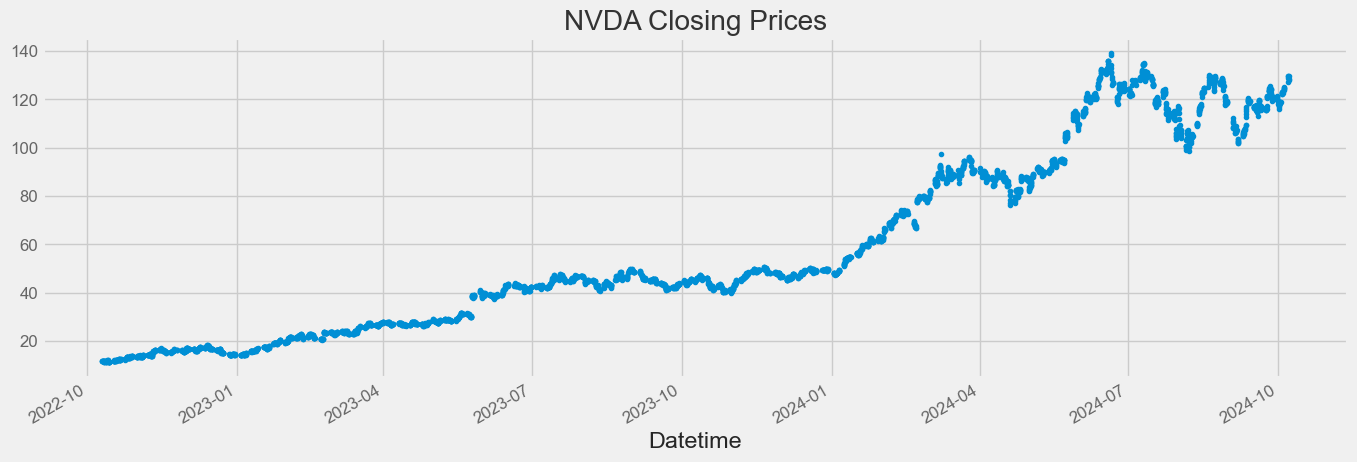

In [155]:
# Visualize data
df['Close'].plot(style='.', figsize = (15,5), color = color_pal[0], title='NVDA Closing Prices');


In [156]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3491.0,5.780701e+01,3.658243e+01,11.035360,2.701736e+01,4.589400e+01,8.854025e+01,1.398500e+02
High,3491.0,5.817503e+01,3.683223e+01,11.336519,2.714300e+01,4.613200e+01,8.899950e+01,1.407600e+02
Low,3491.0,5.740741e+01,3.627968e+01,10.813000,2.688100e+01,4.561900e+01,8.805450e+01,1.378500e+02
Close,3491.0,5.781189e+01,3.657256e+01,11.149990,2.701701e+01,4.588758e+01,8.853850e+01,1.389890e+02
Volume,3491.0,1.231142e+07,1.774224e+07,0.000000,4.043190e+06,5.781456e+06,1.187020e+07,2.197171e+08
Dividends,3491.0,1.260384e-05,2.909551e-04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
Stock Splits,3491.0,2.864509e-03,1.692486e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


### Cleaning & Imputation
Data is already cleaned. No further processing or imputation required.

In [157]:
# Check for missing values
df.isnull().sum()
df.shape

(3491, 7)

## Feature Engineering
Features or Predictors are also known as an independent variable which are used to determine the value of the target variable. We will generate features and label from the original dataset.

In [185]:
# generate features & labels
def generate_xy(frame):
    df = frame.copy()
    df['Returns'] = dailyReturn(df['Close'])

    # Create features (predictors) list
    features_list = []
    for r in range(10, 65, 5):
        df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
        df['Std_'+str(r)] = df.Returns.rolling(r).std()
        features_list.append('Ret_'+str(r))
        features_list.append('Std_'+str(r))

    # Define Target
    df['Label'] = np.where(lead(df['Close']) > 0.995 * df['Close'], 1, 0)  
    # Drop NaN values
    return df.dropna() 

## Feature Specification

In [186]:
# extract features
data = generate_xy(df)
X = data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Label'])
X

,Dividends,Stock Splits,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,...,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-10-20 13:30:00-04:00,0.0,0.0,0.004944,0.021149,0.022524,0.019867,0.019500,0.018227,0.035039,0.016256,...,0.056458,0.019546,0.052293,0.018524,0.040329,0.017973,0.039047,0.017706,0.042470,0.017050
2022-10-20 14:30:00-04:00,0.0,0.0,0.012796,0.021025,0.010887,0.019592,0.025253,0.018191,0.030990,0.016230,...,0.089259,0.018826,0.060593,0.018487,0.039049,0.017970,0.043677,0.017700,0.052153,0.017013
2022-10-20 15:30:00-04:00,0.0,0.0,0.018447,0.020873,0.023293,0.019227,0.017930,0.018150,0.028811,0.016234,...,0.035848,0.016951,0.053226,0.018471,0.058216,0.017724,0.069788,0.017292,0.055653,0.017002
2022-10-21 09:30:00-04:00,0.0,0.0,0.002856,0.020633,0.013949,0.019242,0.036682,0.017338,0.022592,0.016263,...,0.035827,0.016952,0.043482,0.018472,0.046388,0.017711,0.052969,0.017230,0.048202,0.017009
2022-10-21 10:30:00-04:00,0.0,0.0,0.014109,0.020211,-0.015582,0.017593,0.022424,0.017110,0.020066,0.016263,...,0.014661,0.016644,0.049772,0.018436,0.058299,0.017608,0.038314,0.017134,0.036252,0.016951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07 11:30:00-04:00,0.0,0.0,0.053233,0.006228,0.054170,0.006004,0.090223,0.007719,0.097890,0.007507,...,0.082055,0.009390,0.043915,0.009766,0.047558,0.009438,0.049820,0.009586,0.073039,0.009954
2024-10-07 12:30:00-04:00,0.0,0.0,0.054864,0.006015,0.050628,0.006117,0.087129,0.007800,0.101392,0.007375,...,0.071488,0.009321,0.063882,0.009184,0.047531,0.009438,0.046087,0.009586,0.067761,0.009949
2024-10-07 13:30:00-04:00,0.0,0.0,0.048486,0.005975,0.055713,0.005889,0.085996,0.007811,0.092654,0.007235,...,0.066364,0.009276,0.075841,0.009028,0.056202,0.009380,0.050916,0.009577,0.040628,0.009231


In [160]:
# get labels
y = data['Label']

# check class imbalance
pd.Series(y).value_counts()

Label
1    2704
0     727
Name: count, dtype: int64

## Split Data

In [161]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 2744, 687


## Base Model
We now build a base model with default parameters using Pipelines. Dataset needs to be scaled for the model to work properly and all the features should have a similar scale. The scaling can be accomplished by using appropriate transformers. Scaling requirement can however be relaxed for tree-based models.

## Fit Model

In [162]:
# Use pipeline to fit the basemodel
basemodel = XGBClassifier(verbosity = 0, silent=True, random_state=42)

basemodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [163]:
# Predicting the test dataset
y_pred = basemodel.predict(X_test) # gives you the class labels 1, 0,..

# Predict Probabilities # gives you the probabilities of each class labels
y_proba = basemodel.predict_proba(X_test)
# accuracy of the model
acc_train = accuracy_score(y_train, basemodel.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.9996, Test Accuracy: 0.7322


## Prediction Quality
### Confusion Matrix
Confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known.

| Outcome | Position1 |:---------------|:------------| |True Negative | upper-left | |False Negative | lower-left | |False Positive | upper-right | |True Positive | lower-right |

True Positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

False Positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

Note: In a binary classification task, the terms ‘’positive’’ and ‘’negative’’ refer to the classifier’s prediction, and the terms ‘’true’’ and ‘’false’’ refer to whether that prediction corresponds to the external judgment (sometimes known as the ‘’observation’’) and the axes can be flipped. Refer Scikit-Learn Binary Classification for further details.

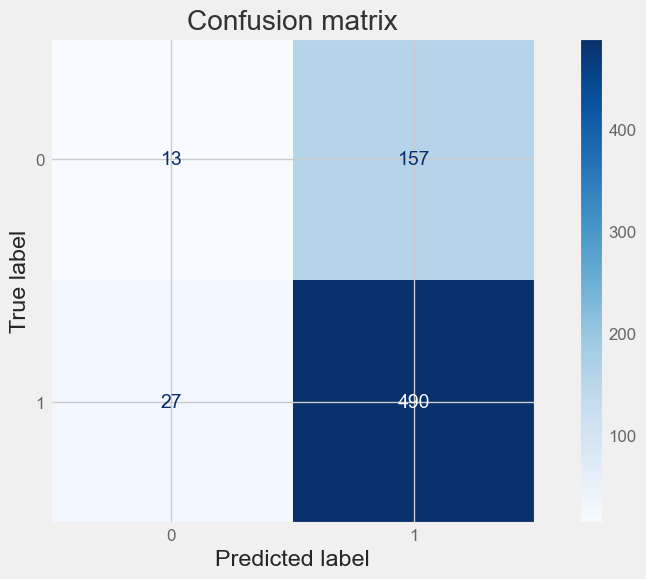

In [164]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        basemodel,
        X_test,
        y_test,
        # display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

In [165]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.08      0.12       170
           1       0.76      0.95      0.84       517

    accuracy                           0.73       687
   macro avg       0.54      0.51      0.48       687
weighted avg       0.65      0.73      0.66       687



## Macro Average
Average of precision (or recall or f1-score) of different classes.

## Weighted Average
Actual Class1 instance * precision (or recall or f1-score) of Class1 + Actual Class2 instance * (or recall or f1-score) of Class2.

## Receiver Operator Characterisitc Curve (ROC)
The area under the ROC curve (AUC) is a measure of how well a model can distinguish between two classes. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.

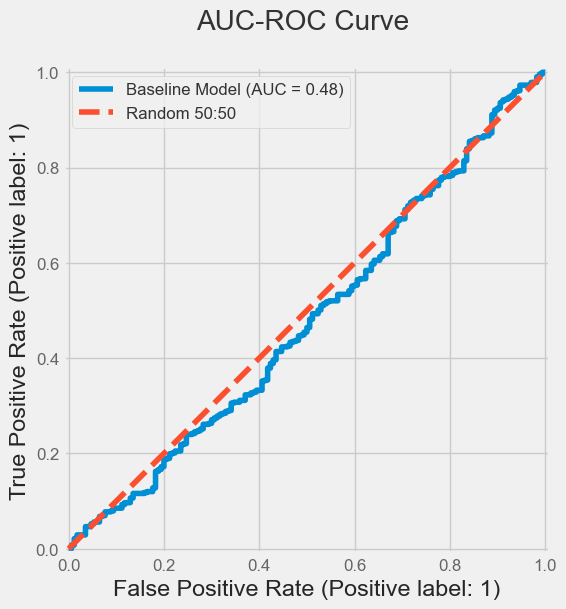

In [166]:
# Display ROCCurve 
disp = RocCurveDisplay.from_estimator(
            basemodel, 
            X_test, 
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [167]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.08      0.12       170
           1       0.76      0.95      0.84       517

    accuracy                           0.73       687
   macro avg       0.54      0.51      0.48       687
weighted avg       0.65      0.73      0.66       687



In [168]:

tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [169]:
from sklearn.model_selection import RandomizedSearchCV

basemodel.get_params()
# Perform Gridsearch and fit
param_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]}

# Perform Gridsearch
rs = RandomizedSearchCV(
                        basemodel,
                        param_grid, 
                        n_iter=100, 
                        scoring='f1', 
                        cv=tscv, 
                        verbose=0
                        )

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [170]:
# predict using the best model
tunedmodel = rs.best_estimator_

# Predict class labels 
y_pred = tunedmodel.predict(X_test)

# Predict Probabilities
# y_proba = tunedmodel.predict_proba(X_test)[:,1]

# Measure Accuracy
acc_train = accuracy_score(y_train, tunedmodel.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.801 
 Test Accuracy 		: 0.7525


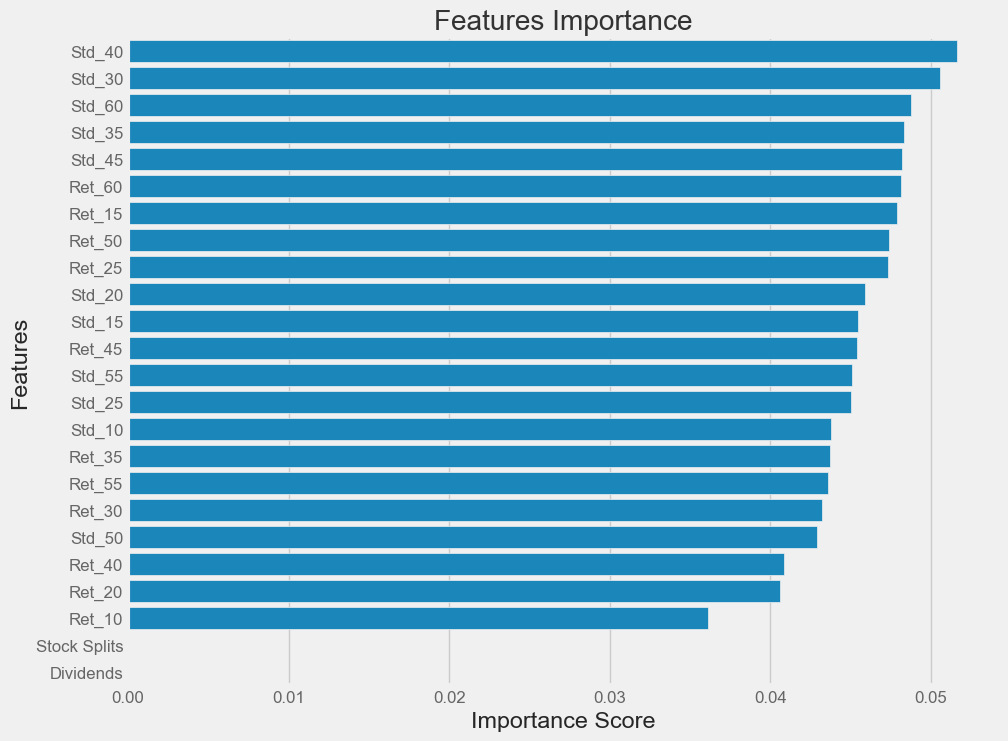

In [171]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': tunedmodel.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

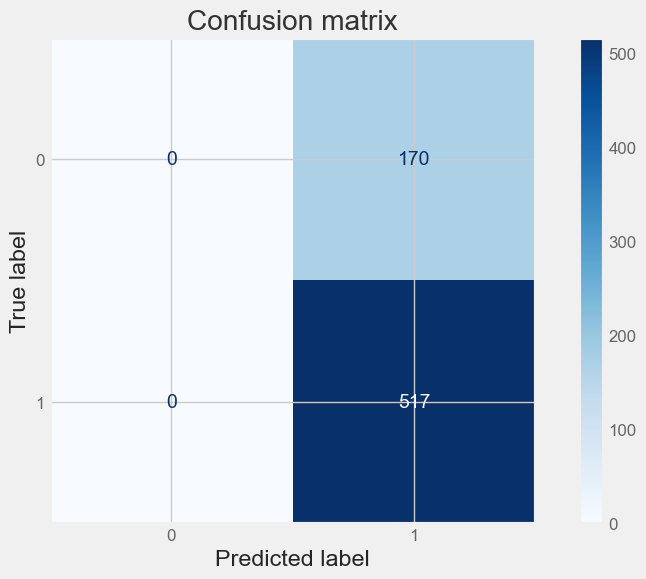

In [172]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        tunedmodel,
        X_test,
        y_test,
        # display_labels=tunedmodel.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

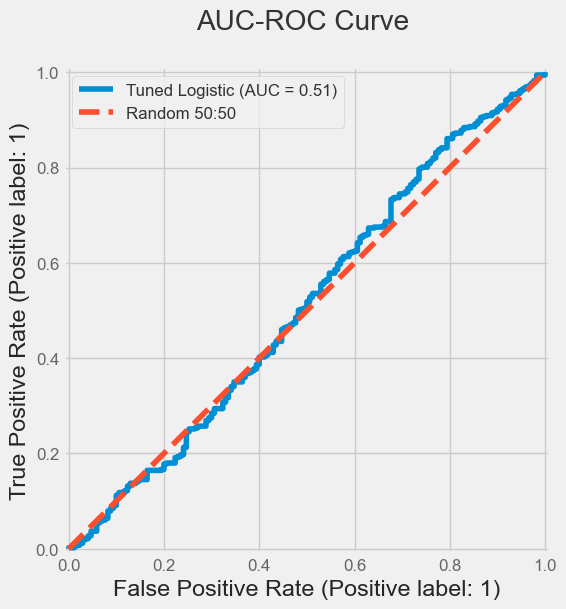

In [173]:
# Display ROCCurve 
disp = RocCurveDisplay.from_estimator(
            tunedmodel, 
            X_test, 
            y_test,
            name='Tuned Logistic')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [174]:
# Shap explainer
explainer = shap.TreeExplainer(tunedmodel)
shap_values = explainer.shap_values(X_test)

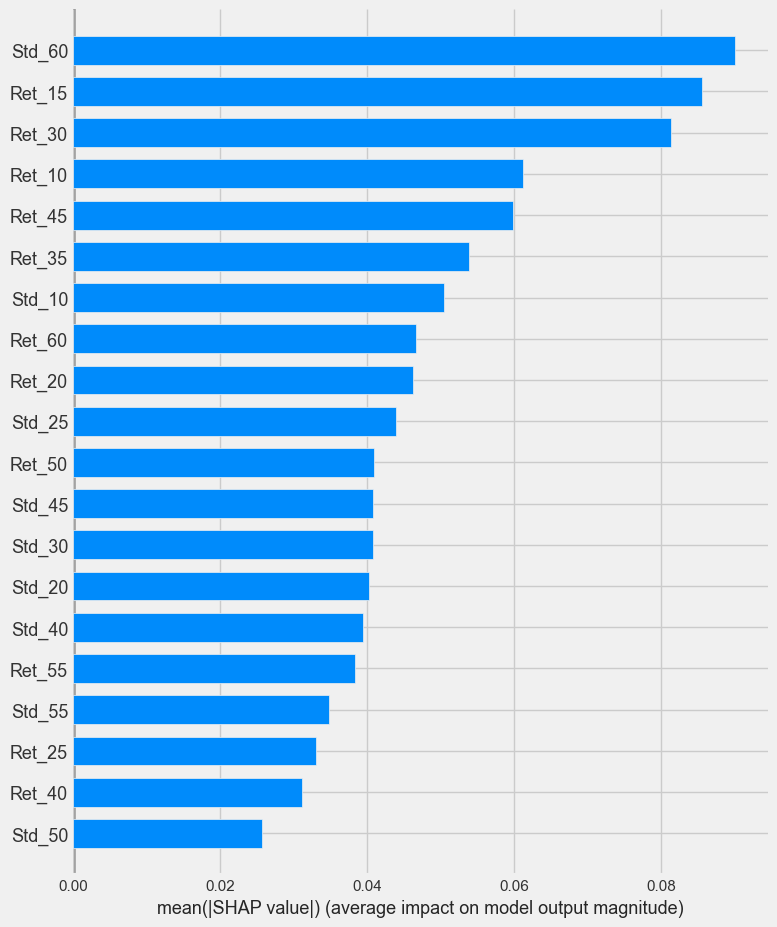

In [175]:
# future importance summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

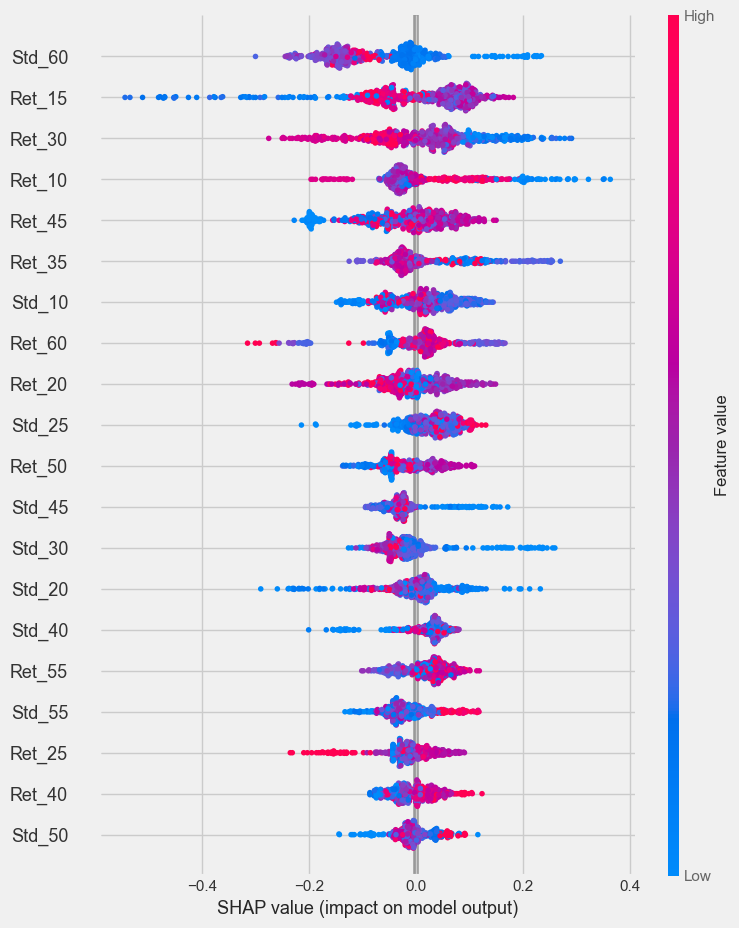

In [176]:
# interpretation plot
shap.summary_plot(shap_values, X_test)

In [177]:
df1 = df[-len(X_test):].copy()                                  # df[-len(X_test):]
df1['Signal'] = tunedmodel.predict(X_test)                      # tunedmodel.predict(X_test)
# Daily Returns - Benchmark return
df1['Returns'] = np.log(df1['Close']).diff().fillna(0)

# Strategy Returns - Logistic
df1['Strategy'] =  df1['Returns'] * df1['Signal'].shift(1).fillna(0)

df1.index = df1.index.tz_convert(None)

df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal,Returns,Strategy
Datetime,,,,,,,,,,
2024-05-16 15:30:00,95.449997,95.541000,94.673996,94.957001,3450020,0.0,0.0,1,0.000000,0.000000
2024-05-16 16:30:00,94.968002,95.074989,94.103004,94.446999,3132610,0.0,0.0,1,-0.005385,-0.005385
2024-05-16 17:30:00,94.443222,94.722000,94.265121,94.443985,2471718,0.0,0.0,1,-0.000032,-0.000032
2024-05-16 18:30:00,94.424957,95.171997,94.414001,94.981003,3015965,0.0,0.0,1,0.005670,0.005670
2024-05-16 19:30:00,94.983002,95.003006,94.281998,94.371002,3073840,0.0,0.0,1,-0.006443,-0.006443
...,...,...,...,...,...,...,...,...,...,...
2024-10-07 15:30:00,128.599899,129.649994,128.550003,129.556305,46140495,0.0,0.0,1,0.007415,0.007415
2024-10-07 16:30:00,129.559402,129.699997,128.809998,129.429703,29112870,0.0,0.0,1,-0.000978,-0.000978
2024-10-07 17:30:00,129.429993,130.639999,129.169998,129.729996,49595566,0.0,0.0,1,0.002317,0.002317


In [178]:
# performance analysis
qs.reports.html(
    df1['Strategy'],
    df1['Returns'],
    title='Strategy Performance',
    output='output/xgbclassifier.html'
)

/Users/maheshnalli/Documents/CQF/EXAMS/Module 4/Exam/.venv/lib/python3.12/site-packages/quantstats_lumi/stats.py:998: RuntimeWarning: invalid value encountered in scalar divide
  return diff_rets.mean() / diff_rets.std()


HTML report saved to: output/xgbclassifier.html


,Returns,Strategy
Metric,,
Risk-Free Rate,0.0%,0.0%
Time in Market,100.0%,100.0%
,,
Total Return,26%,26%
CAGR% (Annual Return),81.39%,81.39%
...,...,...
,,
Beta,-,1.0
Alpha,-,0.0
